In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
def show_image(*imgs, title=''):
    if len(imgs) > 1:
        img = np.concatenate(tuple([x for x in imgs]), axis=1)
    else:
        img = imgs[0]
    fig = plt.figure(figsize=(10,5))
    plt.imshow(img)
    fig.suptitle(title)
    
def show_prediction(prediction):
    resized = np.resize(prediction, (prediction.shape[0], prediction.shape[1]))
    show_image(resized)

In [2]:
from models import get_detector_model, get_classification_model

/home/jamesaustin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/home/jamesaustin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/jamesaustin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


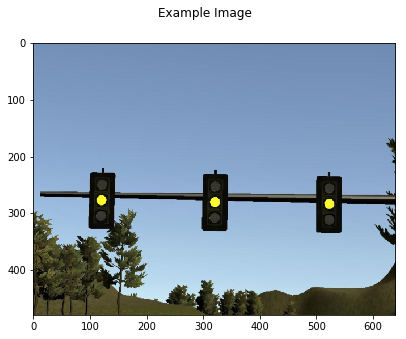

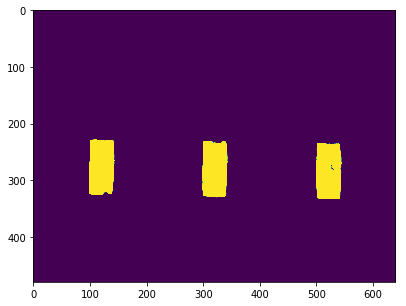

In [15]:
test_image = scipy.misc.imread('./models/data/sim_training_data/sim_data_capture/left0014.jpg')
test_image = scipy.misc.imresize(test_image, (480, 640))
show_image(test_image, title='Example Image')

detector_model = get_detector_model(test_image.shape[0], test_image.shape[1], 
                                    weights_file="./models/fast_traffic_detection_model_v3.hdf5")
def get_prediction(image):
    return detector_model.predict(np.array([image]))[0]
prediction = get_prediction(test_image)
show_prediction(prediction)

In [ ]:
from scipy.ndimage.measurements import label

def apply_threshold(prediction, threshold):
    prediction[prediction <= threshold] = 0
    return prediction
def generate_bounding_box(labels, label):
    nonzero = (labels == label).nonzero()
    # Identify x and y values of those pixels
    #print(sum(nonzero))
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #if len(nonzerox) == 0 or len(nonzeroy) == 0:
    #    return None
    
    # Define a bounding box based on min/max x and y
    total_area = (np.max(nonzerox) - np.min(nonzerox)) * (np.max(nonzeroy) - np.min(nonzeroy))
    if total_area < 10:
        return None
    return ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

def get_image_in_bounding_box(image, bbox):
    a1 = bbox[0][1]
    a2 = bbox[1][1]
    a3 = bbox[0][0]
    a4 = bbox[1][0]
#     print(f"image[{a1}:{a2},{a3}:{a4}]")
    return image[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
#     return image[a1:a2, a3:a4]
#     return image[bbox[0][0]:bbox[1][0],bbox[1][0]:bbox[1][1]]

prediction = apply_threshold(prediction, 0.05)

labels, number_of_lights = label(prediction)

print(f"Number of lights found: {number_of_lights}")

found_traffic_lights = []

for light_number in range(1, number_of_lights+1):
    print(light_number)
    bounding_box = generate_bounding_box(labels, light_number)
    if bounding_box is None:
        continue
    image = get_image_in_bounding_box(test_image, bounding_box)
    found_traffic_lights.append(image)
    print(bounding_box)
    show_image(image)

In [ ]:
labels = {
    'Green': 0,
    'Yellow': 1,
    'Red': 2,
    'unknown': 3
}
reverse_labels = {y: x for x,y in labels.items()}

classification_model = get_classification_model()

def predict_traffic_light(image):
    image = scipy.misc.imresize(image, (64,32))
    prediction = classification_model.predict(np.array([image]))[0]    
    correct_label = np.argmax(prediction)
    return reverse_labels[correct_label]

for image in found_traffic_lights:
    print(predict_traffic_light(image))